In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
from env import *
from wrangle import *
import socket

In [2]:
#Sets options to show more information
pd.options.display.max_columns = None
pd.options.display.width = 100
pd.options.display.max_colwidth = None
pd.options.display.max_rows = 200

In [3]:
df = wrangle_logs()

In [4]:
df.shape

(900223, 16)

In [5]:
staff = df[df.name == 'Staff']

In [6]:
web_dev = df[df.program_id != 3 ]

In [7]:
data_sci = df[df.program_id == 3 ]

In [8]:
students = df[df.name != 'Staff']
students['start_date'] = pd.to_datetime(students['start_date'], infer_datetime_format=True)
students['end_date'] = pd.to_datetime(students['end_date'], infer_datetime_format=True)
active_students = students[(students.index <= students.end_date) & (students.index >= students.start_date)]
lower_quarter = active_students.user_id.value_counts().index[-183:]
lower_quarter_students = active_students[active_students['user_id'].isin(lower_quarter)]
print(lower_quarter_students.groupby('program_id').count()['path'])

program_id
2.0    24724
3.0     5109
Name: path, dtype: int64


In [9]:
not_students = students[(students.index > students.end_date) & (students.index < students.start_date)]

In [10]:
df[df.cohort_id.isna()].user_id.unique()

array([ 48,  58,  78,  61,  79, 111, 354, 365, 363, 353, 366, 357, 369,
       359, 355, 372, 351, 362, 364, 367, 403, 352, 406, 544,  88, 349,
        54,  59,  62,  63,  73,  74,  86,  89, 213, 736, 350, 100, 103,
       137, 166, 176, 356, 358, 360, 361, 368, 375, 429, 247, 317, 815,
       727, 744, 718, 346,  64, 715, 724, 644, 716, 663, 729, 713, 714,
       717, 719, 782, 720, 721, 722, 723, 725, 726, 814, 728, 731, 810])

# 3. Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?

In [11]:
def low_access_users(df):
    """
    This function shows the number of users in web dev (program_id = 2) and data science (program_id = 3) who are in the bottom 25%.
    """
    
    students = df[df.name != 'Staff']
    students['start_date'] = pd.to_datetime(students['start_date'], infer_datetime_format=True)
    students['end_date'] = pd.to_datetime(students['end_date'], infer_datetime_format=True)
    active_students = students[(students.index <= students.end_date) & (students.index >= students.start_date)]
    lower_quarter = active_students.user_id.value_counts().index[-183:]
    lower_quarter_students = active_students[active_students['user_id'].isin(lower_quarter)]
    print("Web Dev program_id = 2")
    print("Data Science program_id = 3")
    print(lower_quarter_students.groupby('program_id').count()['path'])

In [12]:
low_access_users(df)

Web Dev program_id = 2
Data Science program_id = 3
program_id
2.0    24724
3.0     5109
Name: path, dtype: int64


In [13]:
bottom_users = active_students.user_id.value_counts().index[-20:]

In [14]:
for item in bottom_users:
    print(f'************** User: {item} **************')
    print(df[df.user_id == item].groupby('path').count()['user_id'])

************** User: 961 **************
path
/                                                                            2
appendix/git/intellij-intro                                                  1
javascript-i                                                                 1
javascript-i/conditionals                                                    3
javascript-i/functions                                                       2
javascript-i/introduction/operators                                          1
javascript-i/introduction/primitive-types                                    1
javascript-i/introduction/variables                                          1
javascript-i/introduction/working-with-data-types-operators-and-variables    3
javascript-i/javascript-with-html                                            1
javascript-i/testing-user-functions                                          1
toc                                                                          3
Name: u

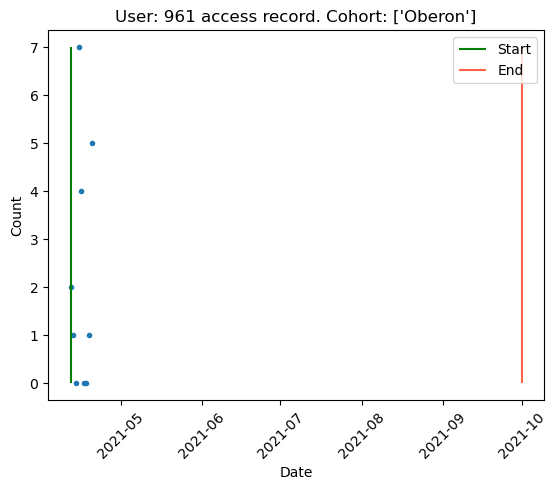

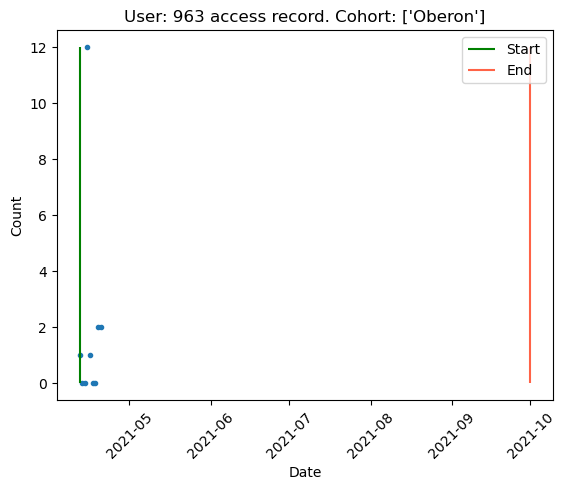

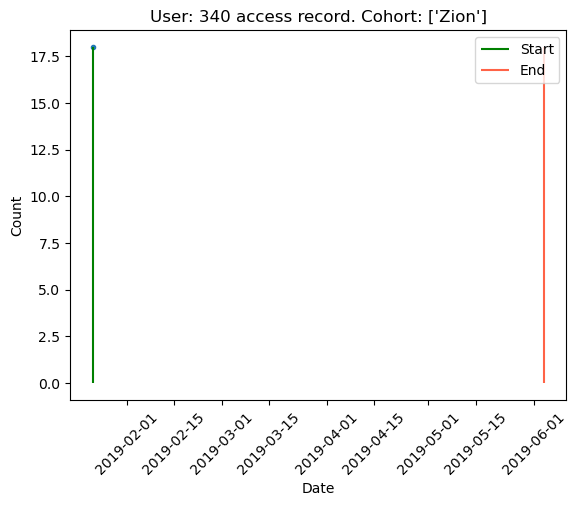

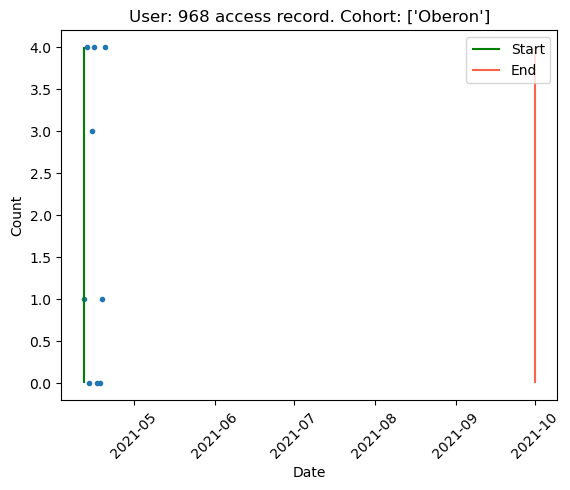

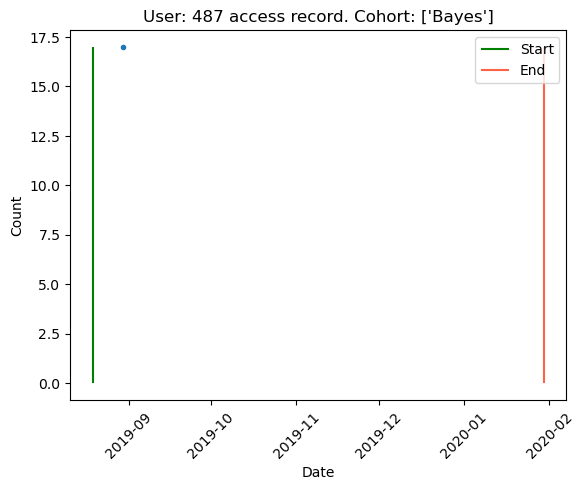

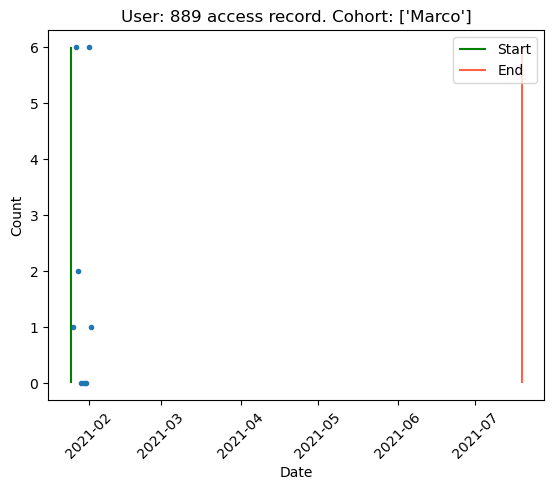

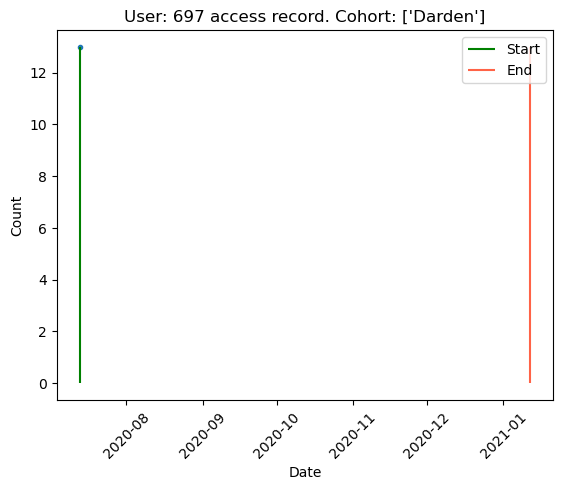

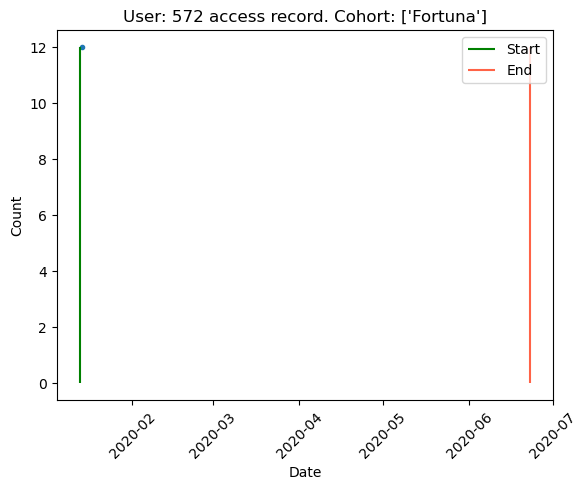

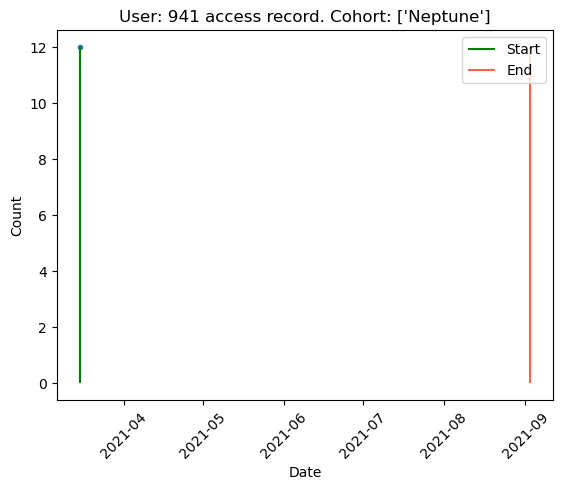

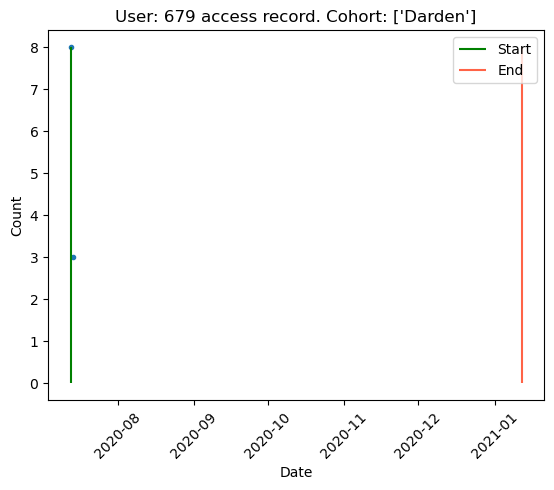

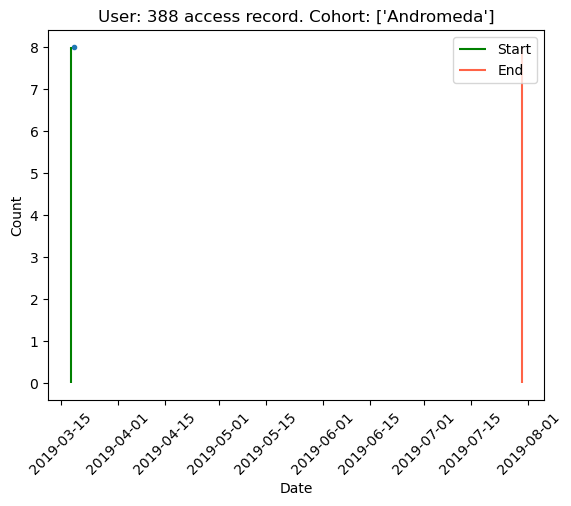

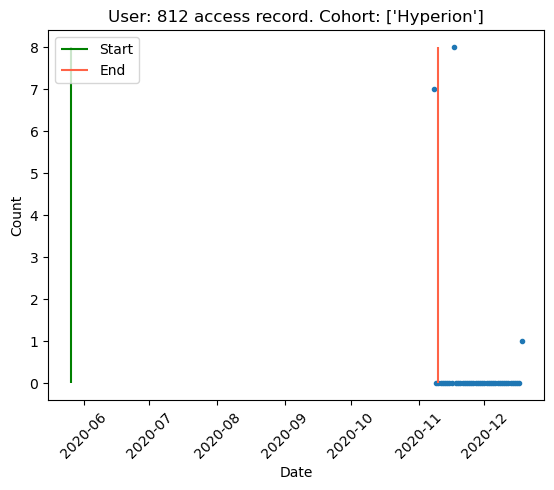

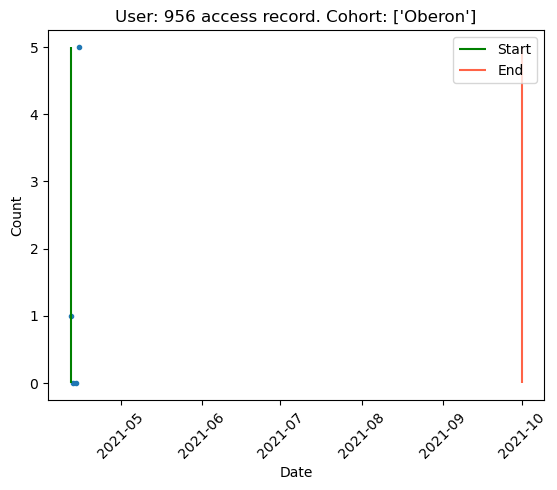

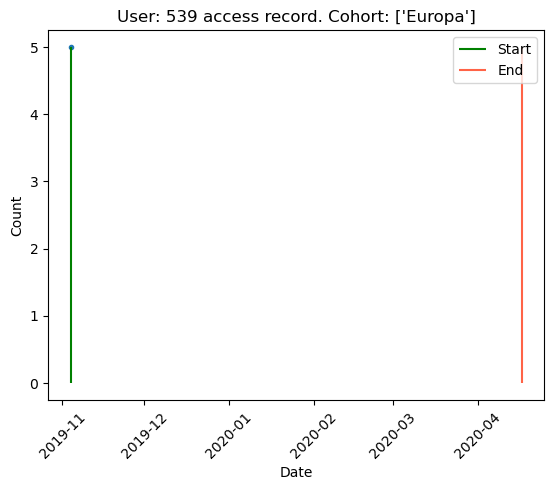

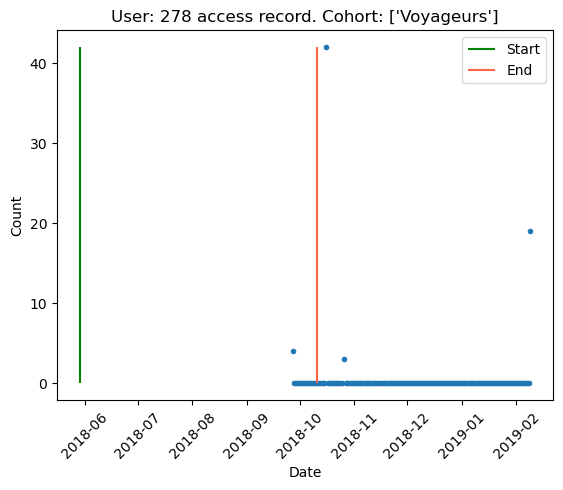

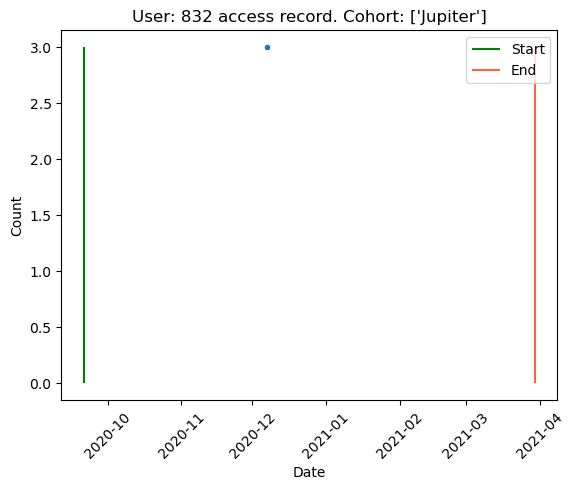

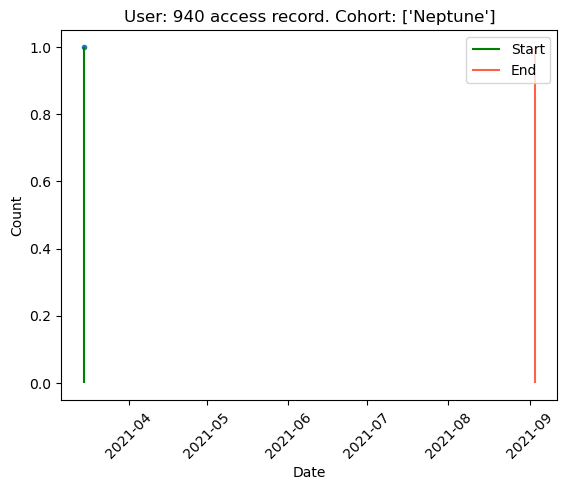

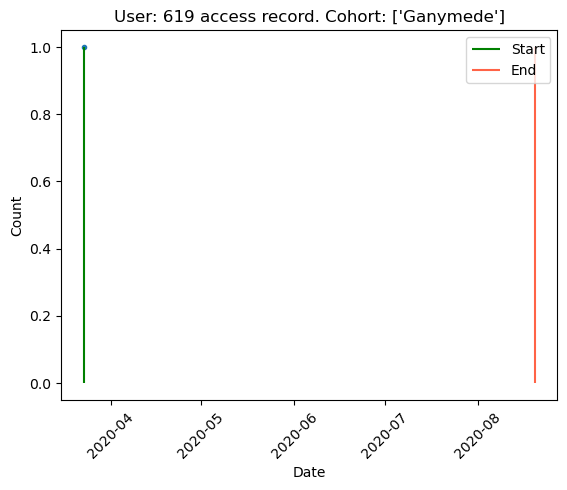

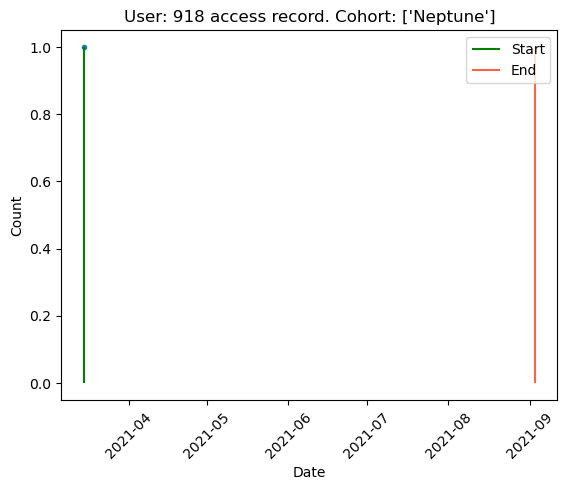

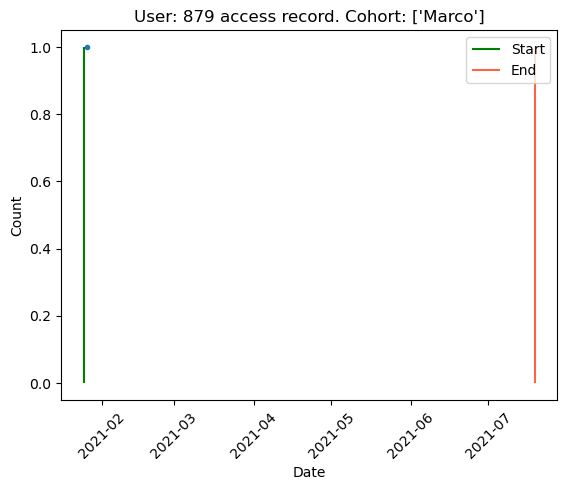

In [15]:
for item in bottom_users:
    user_hits = students[students['user_id'] == item].resample('D').count()
    start_date = students[students['user_id'] == item].start_date.unique()
    end_date = students[students['user_id'] == item].end_date.unique()
    cohort_name = students[students['user_id'] == item].name.unique()
    plt.scatter(x=user_hits.index, y=user_hits.user_id, marker='.')
    plt.vlines(start_date, ymin=0, ymax=user_hits.path.max(), color='green', label='Start')
    plt.vlines(end_date, ymin=0, ymax=user_hits.path.max(), color='tomato', label='End')
    plt.xticks(rotation = 45)
    plt.title(f'User: {item} access record. Cohort: {cohort_name}')
    plt.xlabel("Date")
    plt.ylabel("Count")
    plt.legend()
    plt.show()

In [16]:
lower_quarter = active_students.user_id.value_counts().index[-183:]

In [17]:
lower_quarter

Int64Index([871, 301, 142, 797, 628, 895, 830, 202, 914, 505,
            ...
            388, 812, 956, 539, 278, 832, 940, 619, 918, 879],
           dtype='int64', length=183)

# 4. Is there any suspicious activity, such as users/machines/etc accessing the curriculum who shouldn’t be? Does it appear that any web-scraping is happening? Are there any suspicious IP addresses?

In [18]:
df[df.path.isna() == True]

,time,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id,datetime,ip_name
date,,,,,,,,,,,,,,,,
2020-04-08,09:25:18,NaN,586,55.0,72.177.240.51,55.0,Curie,#curie,2020-02-03,2020-07-07,2020-02-03 19:31:51,2020-02-03 19:31:51,NaN,3.0,2020-04-08 09:25:18,072-177-240-051.res.spectrum.com


In [19]:
ip_list = df.ip.unique()

In [20]:
substring = ".ru"

for item in df.ip_name.unique():
    item = str(item)
    if item.find(substring) != -1:
        print(f'Found: {item}')
    else:
        pass

In [21]:
null_users = df[df.cohort_id.isna()].user_id.unique()

In [22]:
null_users

array([ 48,  58,  78,  61,  79, 111, 354, 365, 363, 353, 366, 357, 369,
       359, 355, 372, 351, 362, 364, 367, 403, 352, 406, 544,  88, 349,
        54,  59,  62,  63,  73,  74,  86,  89, 213, 736, 350, 100, 103,
       137, 166, 176, 356, 358, 360, 361, 368, 375, 429, 247, 317, 815,
       727, 744, 718, 346,  64, 715, 724, 644, 716, 663, 729, 713, 714,
       717, 719, 782, 720, 721, 722, 723, 725, 726, 814, 728, 731, 810])

In [23]:
null_user_df = df[df['user_id'].isin(null_users)]

In [24]:
def view_web_scraping(df):

    null_users = [48, 354, 111, 355, 372]

    for item in null_users:
        plt.plot(df[df.user_id == item].resample('T').count()['path'])
        plt.xticks(rotation = 45)
        plt.title(f'Unathorized user: {item}')
        plt.ylabel("Requests per minute")
        plt.show()

In [25]:
def low_access_users(df):
    """
    This function shows the number of users in web dev (program_id = 2) and data science (program_id = 3) who are in the bottom 25%.
    """
    
    students = df[df.name != 'Staff']
    students['start_date'] = pd.to_datetime(students['start_date'], infer_datetime_format=True)
    students['end_date'] = pd.to_datetime(students['end_date'], infer_datetime_format=True)
    active_students = students[(students.index <= students.end_date) & (students.index >= students.start_date)]
    lower_quarter = active_students.user_id.value_counts().index[-183:]
    lower_quarter_students = active_students[active_students['user_id'].isin(lower_quarter)]
    print("Web Dev program_id = 2")
    print("Data Science program_id = 3")
    print(lower_quarter_students.groupby('program_id').count()['path'])